##### Libraries

In [2]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import chi2_contingency
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

##### Load Data

In [3]:
df = pd.read_excel('../data_processed/activist_people_taliban_tweets.xlsx')

##### Label Data Base on Keywords

In [4]:
def label_tweets(text):
    keywords = ['education', 'school', 'university', 'women', 'girl']
    for keyword in keywords:
        if keyword in text.lower():
            return 1
    return 0
df = df.copy()
df['label'] = df['text'].apply(label_tweets)

##### Sentiment Analysis

In [5]:
x = df['text']
sentiment_labels = []
sentiment_scores = []
for tweet in x:
    # Create a TextBlob object
    blob = TextBlob(tweet)
    # Get the sentiment polarity (-1 to 1)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    
    sentiment_labels.append(sentiment)
    sentiment_scores.append(polarity)
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores

In [6]:
# Add the sentiment labels and scores as new columns in the DataFrame
df['sentiment'] = sentiment_labels
df['sentiment_score'] = sentiment_scores
# Calculate sentiment counts for each gender and sentiment category
sentiment_counts = df.groupby(['group', 'sentiment']).size().unstack()
# Calculate sentiment percentages for each gender
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
# Add the sentiment percentages to the DataFrame
df_sentiment_percentage = pd.DataFrame(sentiment_percentages)
df_sentiment_percentage.columns = [f'{col} %' for col in df_sentiment_percentage.columns]
# Display the DataFrame
df_sentiment_percentage.head()


,negative %,neutral %,positive %
group,,,
activist,22.282148,41.823330,35.894522
people,21.721719,41.114488,37.163793
tablian,21.329472,33.904173,44.766355


In [7]:
df.sample(5)

,text,name,created_at,group,label,sentiment,sentiment_score
114933,secrets war documentary translated iman youtub...,BaryaalOmar,2022-11-22 00:00:00,tablian,0,positive,0.166667
131942,nights view pulekhushbakhti pulesukhta known p...,Hedayatullah111,2023-02-21 00:00:00,tablian,0,negative,-1.000000
177335,mariam tjk unfortunately always fought alone,AmiriMarooo,2022-09-22,people,0,negative,-0.500000
186638,waw ngo steal money woman afghanistan spend am...,Afgwomanright,2022-05-22,people,0,neutral,0.000000
72392,vernosi landaghars hit knife turkey hes fine,BOSSKUNDUZI,2023-02-06 00:00:00,people,0,positive,0.416667


In [8]:
# Add the sentiment labels as a new column in the DataFrame
df['sentiment'] = sentiment_labels

# Filter the DataFrame for each group and count the sentiment labels
group_sentiment_counts = df[df['group'] == 'activist']['sentiment'].value_counts().to_frame('Activist').join(
    df[df['group'] == 'tablian']['sentiment'].value_counts().to_frame('Taliban')).join(
    df[df['group'] == 'people']['sentiment'].value_counts().to_frame('People'))

# Display the counts of positive, negative, and neutral tweets for each group
group_sentiment_counts.head()


,Activist,Taliban,People
sentiment,,,
neutral,21713,25757,43428
positive,18635,34009,39255
negative,11568,16204,22944


##### Sentiment Distribution for Entire Dataset

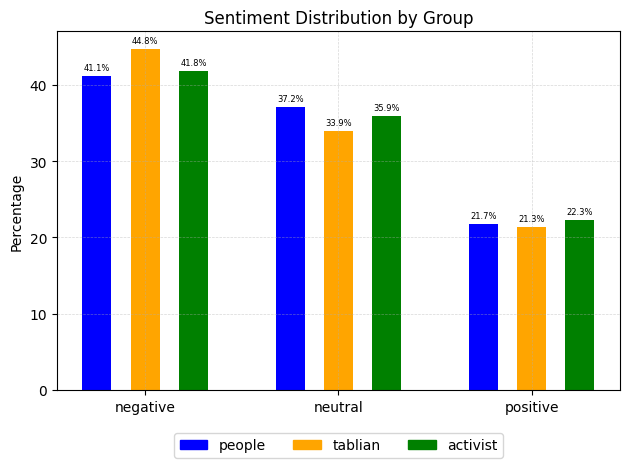

In [9]:
# Calculate sentiment counts for different groups
group_sentiment_counts = df['group'].value_counts()
group_sentiment_percentages = (group_sentiment_counts / group_sentiment_counts.sum()) * 100
# Get all unique sentiment categories
sentiment_categories = sorted(df['sentiment'].unique())
# Set the width of each bar (adjust as desired)
bar_width = 0.15
spacing = 0.1
# Calculate the x positions for the bars
group_x = np.arange(len(sentiment_categories))
# Set the y-axis label
plt.ylabel('Percentage')
# Plot the sentiment percentages for groups
colors = ['blue', 'orange', 'green']  # Add more colors if needed
for i, group in enumerate(group_sentiment_counts.index):
    group_sentiment_percentages = (df[df['group'] == group]['sentiment'].value_counts() / group_sentiment_counts[group]) * 100
    plt.bar(group_x + (i * (bar_width + spacing)), group_sentiment_percentages, width=bar_width, color=colors[i], label=group)
# Set the title at the top
plt.title('Sentiment Distribution by Group')
# Add labels for sentiment categories
plt.xticks(group_x + (len(group_sentiment_counts.index) - 1) * (bar_width + spacing) / 2, sentiment_categories)
# Add color patches and labels for groups below the bars
group_patches = [mpatches.Patch(color=colors[i], label=group) for i, group in enumerate(group_sentiment_counts.index)]
plt.legend(handles=group_patches, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=len(group_sentiment_counts.index))
# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
# Add percentage labels on top of each bar with smaller font size
for i, group in enumerate(group_sentiment_counts.index):
    group_sentiment_percentages = (df[df['group'] == group]['sentiment'].value_counts() / group_sentiment_counts[group]) * 100
    for x, percentage in enumerate(group_sentiment_percentages):
        plt.text(group_x[x] + (i * (bar_width + spacing)), percentage + 0.5, f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=6)
# Adjust the layout to provide space for the percentage labels
plt.tight_layout()
# Show the plot
plt.show()


##### Calculate the total count of positive, negative, and neutral sentiments for each group

In [10]:

group_sentiment_counts = df.groupby('group')['sentiment'].value_counts().unstack(fill_value=0)
# Calculate the total count of each group
group_counts = group_sentiment_counts.sum(axis=1)
# Calculate the percentage of each sentiment category within each group
group_sentiment_percentages = group_sentiment_counts.div(group_counts, axis=0) * 100

# Create a new DataFrame to store the percentages
percentages_df = pd.DataFrame({
    'Group': group_sentiment_counts.index,
    'Positive (%)': group_sentiment_percentages['positive'],
    'Negative (%)': group_sentiment_percentages['negative'],
    'Neutral (%)': group_sentiment_percentages['neutral']
})

# Print the percentages DataFrame
percentages_df.head()


,Group,Positive (%),Negative (%),Neutral (%)
group,,,,
activist,activist,35.894522,22.282148,41.823330
people,people,37.163793,21.721719,41.114488
tablian,tablian,44.766355,21.329472,33.904173


##### Calculate the total count of positive, negative, and neutral sentiments for each group


In [11]:
group_sentiment_counts = df.groupby('group')['sentiment'].value_counts().unstack(fill_value=0)

# Calculate the total count of each group
group_counts = group_sentiment_counts.sum(axis=1)

# Calculate the percentage of each sentiment category within each group
group_sentiment_percentages = group_sentiment_counts.div(group_counts, axis=0) * 100

# Create a new DataFrame to store the totals and percentages
totals_df = pd.DataFrame({
    'Group': group_sentiment_counts.index,
    'Positive': group_sentiment_counts['positive'],
    'Negative': group_sentiment_counts['negative'],
    'Neutral': group_sentiment_counts['neutral'],
    'Positive (%)': group_sentiment_percentages['positive'],
    'Negative (%)': group_sentiment_percentages['negative'],
    'Neutral (%)': group_sentiment_percentages['neutral']
})

# Print the totals DataFrame
totals_df.head()


,Group,Positive,Negative,Neutral,Positive (%),Negative (%),Neutral (%)
group,,,,,,,
activist,activist,18635,11568,21713,35.894522,22.282148,41.823330
people,people,39255,22944,43428,37.163793,21.721719,41.114488
tablian,tablian,34009,16204,25757,44.766355,21.329472,33.904173


##### Group the data by 'group' and calculate the total count for each group


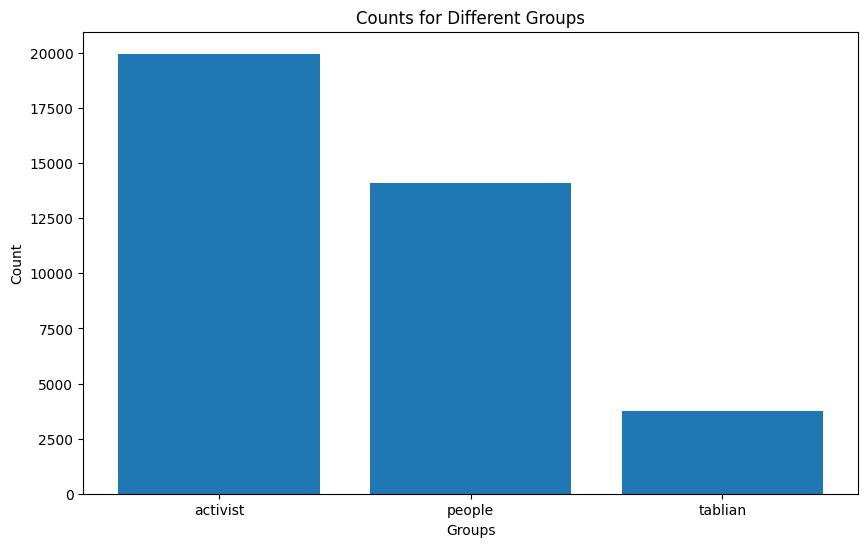

In [12]:
group_counts = df.groupby('group')['label'].sum()

# Get the unique group names in the data
groups = group_counts.index.tolist()

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the grouped bars
ax.bar(groups, group_counts)

# Add labels and title
ax.set_xlabel('Groups')
ax.set_ylabel('Count')
ax.set_title('Counts for Different Groups')

# Show the chart
plt.show()

# print(group_counts)

##### Average score for activists

In [13]:
# Filter the dataframe for the activist group and tweets related to women's education
activist_women_edu_tweets = df[(df['group'] == 'activist') & (df['text'].str.contains('women education|girls education|gender equality in education', case=False))]
# Calculate the average sentiment score for the activist group
avg_sentiment_score_activist = activist_women_edu_tweets['sentiment_score'].mean()
# Print the average sentiment score
print("Average Sentiment Score (Activist):", avg_sentiment_score_activist)


Average Sentiment Score (Activist): 0.056625748949118516


##### keywords = ['education', 'school', 'university', 'women', 'girl']

##### Activists

In [14]:
# Create an empty list to store the sentiment distributions for the activist group
activist_sentiment_data = []
activists_group_keywords = ['women', 'education', 'school', 'university', 'girl']
# Loop through each keyword and calculate the sentiment distribution for the activist group
for keyword in activists_group_keywords:
    # Filter the dataset for tweets containing the keyword and belonging to the activist group
    keyword_tweets_activist = df[(df['text'].str.contains(keyword)) & (df['group'] == 'activist')].copy()

    # Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
    keyword_tweets_activist['sentiment_score'] = keyword_tweets_activist['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

    # Calculate the sentiment distribution for the activist group
    sentiment_distribution_activist = keyword_tweets_activist['sentiment'].value_counts(normalize=True) * 100

    # Append the sentiment distribution for the activist group to the activist_sentiment_data list
    activist_sentiment_data.append(sentiment_distribution_activist)

# Create a DataFrame for the sentiment distribution of the activist group
activist_sentiment_df = pd.DataFrame(activist_sentiment_data, index=activists_group_keywords)
activist_sentiment_df.head()

sentiment,neutral,positive,negative
women,44.416093,36.905673,18.678234
education,35.434549,46.405579,18.159871
school,42.669469,31.529164,25.801366
university,49.434389,32.522624,18.042986
girl,42.055817,35.134015,22.810169


##### Taliban

In [15]:
# Create an empty list to store the sentiment distributions for the Taliban group
taliban_sentiment_data = []
taliban_keywords = ['women', 'education', 'school', 'university', 'girl']

# Loop through each keyword and calculate the sentiment distribution for the Taliban group
for keyword in taliban_keywords:
    # Filter the dataset for tweets containing the keyword and belonging to the Taliban group
    keyword_tweets_taliban = df[(df['text'].str.contains(keyword)) & (df['group'] == 'Taliban')].copy()

    if not keyword_tweets_taliban.empty:
        # Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
        keyword_tweets_taliban['sentiment_score'] = keyword_tweets_taliban['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

        # Calculate the sentiment distribution for the Taliban group
        sentiment_distribution_taliban = keyword_tweets_taliban['sentiment'].value_counts(normalize=True) * 100

        # Append the sentiment distribution for the Taliban group to the taliban_sentiment_data list
        taliban_sentiment_data.append(sentiment_distribution_taliban)

# Create a DataFrame for the sentiment distribution of the Taliban group
taliban_sentiment_df = pd.DataFrame(taliban_sentiment_data, index=taliban_keywords)
taliban_sentiment_df.head()


""
women
education
school
university
girl


In [18]:
# Create an empty list to store the sentiment distributions for the people group
people_sentiment_data = []
keywords_people = ['women', 'education', 'school', 'university', 'girl']

# Loop through each keyword and calculate the sentiment distribution for the people group
for keyword in keywords_people:
    # Filter the dataset for tweets containing the keyword and belonging to the people group
    keyword_tweets_people = df[(df['text'].str.contains(keyword)) & (df['group'] == 'people')].copy()

    # Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
    keyword_tweets_people['sentiment_score'] = keyword_tweets_people['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

    # Calculate the sentiment distribution for the people group
    sentiment_distribution_people = keyword_tweets_people['sentiment'].value_counts(normalize=True) * 100

    # Append the sentiment distribution for the people group to the people_sentiment_data list
    people_sentiment_data.append(sentiment_distribution_people)

# Create a DataFrame for the sentiment distribution of the people group
people_sentiment_df = pd.DataFrame(people_sentiment_data, index=keywords_people)
people_sentiment_df.head()

sentiment,positive,neutral,negative
women,41.587384,37.716669,20.695947
education,49.155088,30.454375,20.390537
school,38.451668,34.174508,27.373824
university,38.589841,36.694466,24.715694
girl,39.754964,37.198986,23.046050


In [19]:
# Create empty lists to store the sentiment distributions for different groups
activist_sentiment_data = []
taliban_sentiment_data = []
people_sentiment_data = []
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
five_keywords_regarding_label_1 = ['women', 'education', 'school', 'university', 'girl']

for keyword in five_keywords_regarding_label_1:
    keyword_tweets_activist = df[(df['text'].str.contains(keyword)) & (df['group'] == 'activist')].copy()
    keyword_tweets_taliban = df[(df['text'].str.contains(keyword)) & (df['group'] == 'taliban')].copy()
    keyword_tweets_people = df[(df['text'].str.contains(keyword)) & (df['group'] == 'people')].copy()
    
    # Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
    keyword_tweets_activist['sentiment_score'] = keyword_tweets_activist['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    keyword_tweets_taliban['sentiment_score'] = keyword_tweets_taliban['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    keyword_tweets_people['sentiment_score'] = keyword_tweets_people['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Calculate the sentiment distribution for activists
    sentiment_distribution_activist = keyword_tweets_activist['sentiment'].value_counts(normalize=True) * 100
    
    # Calculate the sentiment distribution for taliban
    sentiment_distribution_taliban = keyword_tweets_taliban['sentiment'].value_counts(normalize=True) * 100
    
    # Calculate the sentiment distribution for people
    sentiment_distribution_people = keyword_tweets_people['sentiment'].value_counts(normalize=True) * 100
    
    # Append the sentiment distributions for different groups to the respective lists
    activist_sentiment_data.append(sentiment_distribution_activist)
    taliban_sentiment_data.append(sentiment_distribution_taliban)
    people_sentiment_data.append(sentiment_distribution_people)

# Create DataFrames for sentiment distributions of different groups
activist_sentiment_df = pd.DataFrame(activist_sentiment_data, index=five_keywords_regarding_label_1)
taliban_sentiment_df = pd.DataFrame(taliban_sentiment_data, index=five_keywords_regarding_label_1)
people_sentiment_df = pd.DataFrame(people_sentiment_data, index=five_keywords_regarding_label_1)

# Transpose the DataFrames to have sentiment categories as columns
activist_sentiment_df = activist_sentiment_df.T
taliban_sentiment_df = taliban_sentiment_df.T
people_sentiment_df = people_sentiment_df.T

# Combine the DataFrames of different groups into a single DataFrame
combined_sentiment_df = pd.concat([activist_sentiment_df, taliban_sentiment_df, people_sentiment_df], axis=1, keys=['Activist', 'Taliban', 'People'])

# Format the sentiment percentages to display two decimal places
combined_sentiment_df = combined_sentiment_df.round(2)

# Print the combined DataFrame
print("Combined Sentiment Analysis:")
combined_sentiment_df.head()


Combined Sentiment Analysis:


Activist                                    Taliban            \
             women education school university   girl   women education   
sentiment                                                                 
neutral      44.42     35.43  42.67      49.43  42.06     NaN       NaN   
positive     36.91     46.41  31.53      32.52  35.13     NaN       NaN   
negative     18.68     18.16  25.80      18.04  22.81     NaN       NaN   

                                 People                                     
          school university girl  women education school university   girl  
sentiment                                                                   
neutral      NaN        NaN  NaN  37.72     30.45  34.17      36.69  37.20  
positive     NaN        NaN  NaN  41.59     49.16  38.45      38.59  39.75  
negative     NaN        NaN  NaN  20.70     20.39  27.37      24.72  23.05

In [35]:
# Create empty lists to store the sentiment distributions for different groups
activist_sentiment_data = []
taliban_sentiment_data = []
people_sentiment_data = []
# Loop through each keyword and calculate the sentiment of tweets containing that keyword
five_keywords_regarding_label_1 = ['women education']

for keyword in five_keywords_regarding_label_1:
    keyword_tweets_activist = df[(df['text'].str.contains(keyword)) & (df['group'] == 'activist')].copy()
    keyword_tweets_taliban = df[(df['text'].str.contains(keyword)) & (df['group'] == 'taliban')].copy()
    keyword_tweets_people = df[(df['text'].str.contains(keyword)) & (df['group'] == 'people')].copy()
    
    # Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
    keyword_tweets_activist['sentiment_score'] = keyword_tweets_activist['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    keyword_tweets_taliban['sentiment_score'] = keyword_tweets_taliban['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    keyword_tweets_people['sentiment_score'] = keyword_tweets_people['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    # Calculate the sentiment distribution for activists
    sentiment_distribution_activist = keyword_tweets_activist['sentiment'].value_counts(normalize=True) * 100
    
    # Calculate the sentiment distribution for taliban
    sentiment_distribution_taliban = keyword_tweets_taliban['sentiment'].value_counts(normalize=True) * 100
    
    # Calculate the sentiment distribution for people
    sentiment_distribution_people = keyword_tweets_people['sentiment'].value_counts(normalize=True) * 100
    
    # Append the sentiment distributions for different groups to the respective lists
    activist_sentiment_data.append(sentiment_distribution_activist)
    taliban_sentiment_data.append(sentiment_distribution_taliban)
    people_sentiment_data.append(sentiment_distribution_people)

# Create DataFrames for sentiment distributions of different groups
activist_sentiment_df = pd.DataFrame(activist_sentiment_data, index=five_keywords_regarding_label_1)
taliban_sentiment_df = pd.DataFrame(taliban_sentiment_data, index=five_keywords_regarding_label_1)
people_sentiment_df = pd.DataFrame(people_sentiment_data, index=five_keywords_regarding_label_1)

# Transpose the DataFrames to have sentiment categories as columns
activist_sentiment_df = activist_sentiment_df.T
taliban_sentiment_df = taliban_sentiment_df.T
people_sentiment_df = people_sentiment_df.T

# Combine the DataFrames of different groups into a single DataFrame
combined_sentiment_df = pd.concat([activist_sentiment_df, taliban_sentiment_df, people_sentiment_df], axis=1, keys=['Activist', 'Taliban', 'People'])

# Format the sentiment percentages to display two decimal places
combined_sentiment_df = combined_sentiment_df.round(2)

# Print the combined DataFrame
print("Combined Sentiment Analysis:")
combined_sentiment_df.head()


Combined Sentiment Analysis:


,Activist,Taliban,People
,women educatoin,women educatoin,women educatoin
sentiment,,,


##### Only Activists on women education keyword, activists

In [20]:
# Define the keyword 'women education'
activists_women_education = ['women education']
# Create an empty DataFrame to store the sentiment distribution for the activist group
activist_sentiment_df = pd.DataFrame(index=['women education'])
# Filter the dataframe based on the 'activist' group and the keyword 'women education'
activist_keyword_tweets = df[(df['group'] == 'activist') & (df['text'].str.contains(activists_women_education[0], case=False))].copy()
# Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
activist_keyword_tweets['sentiment_score'] = activist_keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
# Calculate the sentiment distribution for the activist group
sentiment_distribution_activist = activist_keyword_tweets['sentiment'].value_counts(normalize=True) * 100
# Add the sentiment distribution to the activist_sentiment_df DataFrame
activist_sentiment_df = sentiment_distribution_activist
# Print the sentiment distribution for the activist group
# print("Sentiment Distribution for 'women education' in the activist group:")
activist_sentiment_df.head()

sentiment
neutral     52.459016
positive    36.065574
negative    11.475410
Name: proportion, dtype: float64

##### People

In [21]:
# Define the keyword 'women education'
people_women_education = ['women education']
# Create an empty DataFrame to store the sentiment distribution for the activist group
people_sentiment_df = pd.DataFrame(index=['women education'])
# Filter the dataframe based on the 'activist' group and the keyword 'women education'
people_keyword_tweets = df[(df['group'] == 'people') & (df['text'].str.contains(people_women_education[0], case=False))].copy()
# Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
people_keyword_tweets['sentiment_score'] = people_keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
# Calculate the sentiment distribution for the activist group
sentiment_distribution_activist = people_keyword_tweets['sentiment'].value_counts(normalize=True) * 100
# Add the sentiment distribution to the people_sentiment_df DataFrame
people_sentiment_df = sentiment_distribution_activist
# Print the sentiment distribution for the activist group
print("Sentiment Distribution for 'women education' in the people group:")
people_sentiment_df.head()


Sentiment Distribution for 'women education' in the people group:


sentiment
positive    44.954128
neutral     33.944954
negative    21.100917
Name: proportion, dtype: float64

##### Taliban

In [22]:
# Define the keyword 'women education'
taliban_women_education = ['women education']
# Create an empty DataFrame to store the sentiment distribution for the activist group
taliban_sentiment_df = pd.DataFrame(index=['women education'])
# Filter the dataframe based on the 'activist' group and the keyword 'women education'
taliban_keyword_tweets = df[(df['group'] == 'taliban') & (df['text'].str.contains(taliban_women_education[0], case=False))].copy()
# Calculate the sentiment score for each tweet using SentimentIntensityAnalyzer
taliban_keyword_tweets['sentiment_score'] = taliban_keyword_tweets['text'].apply(lambda x: sid.polarity_scores(x)['compound'])
# Calculate the sentiment distribution for the activist group
sentiment_distribution_activist = taliban_keyword_tweets['sentiment'].value_counts(normalize=True) * 100
# Add the sentiment distribution to the taliban_sentiment_df DataFrame
taliban_sentiment_df = sentiment_distribution_activist
# Print the sentiment distribution for the activist group
print("Sentiment Distribution for 'women education' in the Taliban group:")
print(taliban_sentiment_df)


Sentiment Distribution for 'women education' in the Taliban group:
Series([], Name: proportion, dtype: float64)


##### Percentage Women Education Keyword

In [23]:
# Define the keyword 'women education'
keyword_women_education = ['women education']
# Create an empty DataFrame to store the keyword counts and percentages for each group
keyword_df = pd.DataFrame(columns=['Group', 'Label 1 Percentage', 'Label 1 Count'])
# Iterate over each group
for group in groups:
    # Filter the dataframe based on the current group and keyword
    group_keyword_counts = df[(df['group'] == group) & (df['text'].str.contains(keyword_women_education[0], case=False))]
    # Count the number of label 1 occurrences
    label1_count = group_keyword_counts[group_keyword_counts['label'] == 1].shape[0]
    # Calculate the percentage of label 1 occurrences
    if group_keyword_counts.shape[0] != 0:
        label1_percentage = (label1_count / group_keyword_counts.shape[0]) * 100
    else:
        label1_percentage = 0
    # Add the group, label 1 percentage, and label 1 count to the keyword DataFrame
    keyword_df.loc[len(keyword_df)] = [group, label1_percentage, label1_count]
# Print the keyword DataFrame
print("Percentage Women Education Keyword")
keyword_df.head()


Percentage Women Education Keyword


,Group,Label 1 Percentage,Label 1 Count
0,activist,100.0,183
1,people,100.0,109
2,tablian,100.0,4


In [24]:
# Define the keyword 'women education'
keyword_women_education = ['women education']
# Create an empty DataFrame to store the keyword counts and percentages for each group
keyword_df = pd.DataFrame(columns=['Group', 'Keyword Percentage'])
# Iterate over each group
for group in groups:
    # Count the number of tweets containing the keyword 'women education' for the current group
    keyword_count = df[(df['group'] == group) & (df['text'].str.contains(keyword_women_education[0], case=False))].shape[0]
    # Calculate the percentage of tweets containing the keyword relative to the total number of tweets for the group
    total_count = df[df['group'] == group].shape[0]
    keyword_percentage = (keyword_count / total_count) * 100 if total_count != 0 else 0
    # Add the group and keyword percentage to the DataFrame
    keyword_df.loc[len(keyword_df)] = [group, keyword_percentage]

# Print the keyword DataFrame
print("Percentage Women Education Keyword")
keyword_df.head()


Percentage Women Education Keyword


,Group,Keyword Percentage
0,activist,0.352492
1,people,0.103193
2,tablian,0.005265


<Figure size 1200x600 with 0 Axes>

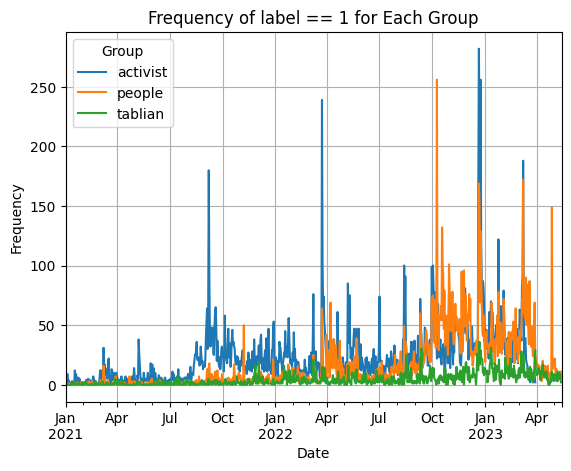

In [25]:
# Convert the 'created_at' column to datetime if it is not already in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Set the 'created_at' column as the index
df.set_index('created_at', inplace=True)

# Group the data by group and resample by a specific time period (e.g., daily, hourly) to count the occurrences of label == 1
label1_frequency = df[df['label'] == 1].groupby('group').resample('D').size().unstack(level=0)  # Resample by day (change 'D' to other frequencies as needed)

# Plot the frequency of label == 1 for each group over time
plt.figure(figsize=(12, 6))
label1_frequency.plot()
plt.title('Frequency of label == 1 for Each Group')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.legend(title='Group')
plt.grid(True)
plt.show()


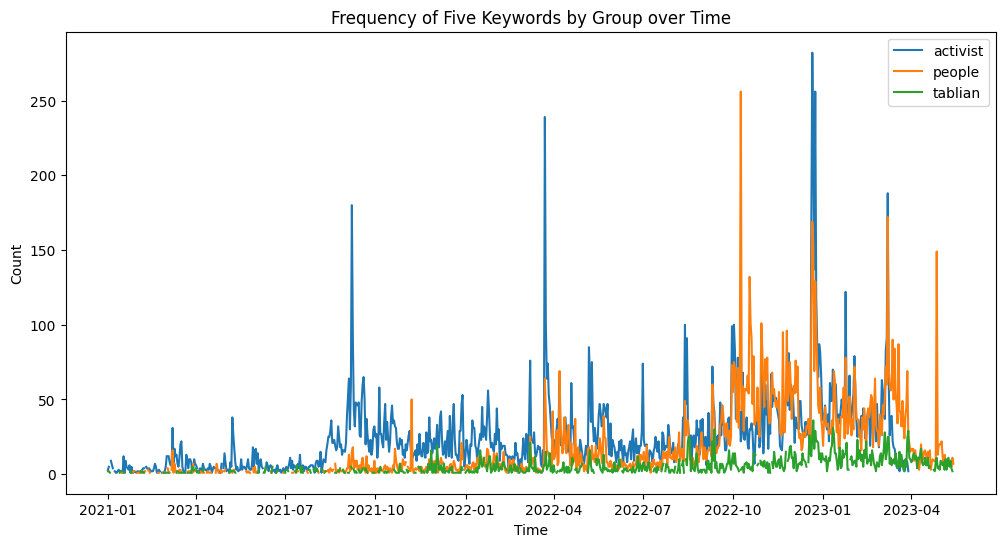

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the dataframe for label == 1
label1_df = df[df['label'] == 1]

# Group the data by 'created_at' and 'group' to count the occurrences of label == 1
group_counts = label1_df.groupby(['created_at', 'group']).size().unstack()

# Extract the time periods and convert them to datetime objects
time_periods = pd.to_datetime(group_counts.index)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the line plot for each group
for group in group_counts.columns:
    ax.plot(time_periods, group_counts[group], label=group)

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Frequency of Five Keywords by Group over Time')

# Add legend
ax.legend()

# Show the chart
plt.show()


##### Chi-square

In [27]:
# Filter the dataframe for the "activist" group and label == 1
activist_label1 = df[(df['group'] == 'activist') & (df['label'] == 1)]
# Create a contingency table for the "activist" group and label == 1 using pivot_table
contingency_table = pd.pivot_table(activist_label1, index='group', columns='label', aggfunc=len, fill_value=0)
# Perform chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)
# Print the results
print("Chi-square Test (Activist)")
print("Chi-square statistic: ", chi2)
print("P-value: ", p_value)


Chi-square Test (Activist)
Chi-square statistic:  0.0
P-value:  1.0


##### People

In [28]:
# Filter the dataframe for the "activist" group and label == 1
people_label1 = df[(df['group'] == 'people') & (df['label'] == 1)]
# Create a contingency table for the "activist" group and label == 1 using pivot_table
poepl_contingency_table = pd.pivot_table(people_label1, index='group', columns='label', aggfunc=len, fill_value=0)
# Perform chi-square test
chi2, p_value, _, _ = chi2_contingency(poepl_contingency_table)
# Print the results
print("Chi-square Test (Activist)")
print("Chi-square statistic: ", chi2)
print("P-value: ", p_value)


Chi-square Test (Activist)
Chi-square statistic:  0.0
P-value:  1.0


##### Taliban

In [29]:
activist_freq = len(df[(df['group'] == 'activist') & (df['label'] == 1)])
people_freq = len(df[(df['group'] == 'people') & (df['label'] == 1)])
taliban_freq = len(df[(df['group'] == 'taliban') & (df['label'] == 1)])

print("Frequency of label == 1:")
print("Activists:", activist_freq)
print("Ordinary People:", people_freq)
print("Taliban:", taliban_freq)


Frequency of label == 1:
Activists: 19964
Ordinary People: 14110
Taliban: 0


In [30]:
keyword_labels = ['women', 'education', 'university', 'school', 'girl']
# Calculate the frequencies of label == 1 tweets for each group and keyword
activist_freq = np.sum(df[df['group'] == 'activists']['text'].str.contains('|'.join(keyword_labels), case=False, regex=True))

# Create the contingency table
contingency_table = pd.DataFrame({'Activists': [activist_freq]})

# Add a small value (e.g., 0.5) to the zero frequency cells
contingency_table += 0.5

# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p_value)



Chi-square statistic: 0.0
P-value: 1.0


##### Crosstable, for group and label == 1

In [31]:
crosstab_df = pd.DataFrame(pd.crosstab(df['group'], df['label'] == 1))
crosstab_df.head()


label,False,True
group,,
activist,31952,19964
people,91517,14110
tablian,72213,3757


In [32]:
# Perform the chi-square test of independence
chi2, p_value, _, _ = chi2_contingency(crosstab_df)
# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p_value)


Chi-square statistic: 26655.354403995017
P-value: 0.0


In [33]:
# import speech_recognition as sr
# r = sr.Recognizer()
# with sr.AudioFile("../data_processed/Sex addiction.wav") as source:
#     audio_data = r.record(source)
#     text = r.recognize_google(audio_data)
# print(text)


In [34]:
# import speech_recognition as sr
# from docx import Document

# # Speech recognition
# r = sr.Recognizer()

# # Load audio file
# audio_file = "../data_processed/sex.wav"

# # Convert audio to text
# with sr.AudioFile(audio_file) as source:
#     audio_data = r.record(source)
#     text = r.recognize_google(audio_data)

# # Split text into paragraphs
# paragraphs = text.split("\n")

# # Save paragraphs to a Word document
# document = Document()
# for paragraph in paragraphs:
#     document.add_paragraph(paragraph)
# document.save("output.docx")
